# Introduction
#### In this notebook, we will predict the price of Air ticket

In [1]:
import pandas as pd
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.metrics import r2_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import Ridge, Lasso
warnings.filterwarnings("ignore")

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')


In [2]:
train.sort_values('Date_of_Journey',axis=0,inplace=True,ignore_index=True)
train

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Air India,01-03-2019,Banglore,New Delhi,11:50,02-03-2021 13:00,25h 10m,1 stop,1 Long layover,15434.0
1,Jet Airways,01-03-2019,Banglore,New Delhi,08:00,02-03-2021 07:40,23h 40m,1 stop,No info,22270.0
2,Air India,01-03-2019,Banglore,New Delhi,08:50,02-03-2021 09:25,24h 35m,2 stops,No info,25430.0
3,Air India,01-03-2019,Banglore,New Delhi,00:30,20:30,20h,1 stop,1 Long layover,14752.0
4,IndiGo,01-03-2019,Banglore,New Delhi,05:15,10:00,4h 45m,1 stop,No Info,8064.0
...,...,...,...,...,...,...,...,...,...,...
8528,Jet Airways,27-06-2019,Mumbai,Hyderabad,10:20,11:50,1h 30m,non-stop,No info,8040.0
8529,Jet Airways,27-06-2019,Delhi,Cochin,11:45,28-06-2021 12:35,24h 50m,2 stops,No info,13882.0
8530,Air India,27-06-2019,Delhi,Cochin,16:40,28-06-2021 19:15,26h 35m,2 stops,No info,9653.0
8531,Air India,27-06-2019,Delhi,Cochin,17:20,28-06-2021 09:25,16h 5m,1 stop,No info,7480.0


In [3]:
train.dtypes

Airline             object
Date_of_Journey     object
Source              object
Destination         object
Dep_Time            object
Arrival_Time        object
Duration            object
Total_Stops         object
Additional_Info     object
Price              float64
dtype: object

# EDA

In [4]:
train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

<AxesSubplot:xlabel='Airline', ylabel='count'>

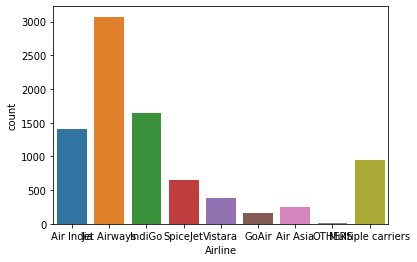

In [5]:
sns.countplot(train["Airline"])

In [6]:
train["Airline"].value_counts()

Jet Airways          3073
IndiGo               1641
Air India            1401
Multiple carriers     953
SpiceJet              654
Vistara               384
Air Asia              256
GoAir                 157
OTHERS                 14
Name: Airline, dtype: int64

<AxesSubplot:xlabel='Source', ylabel='count'>

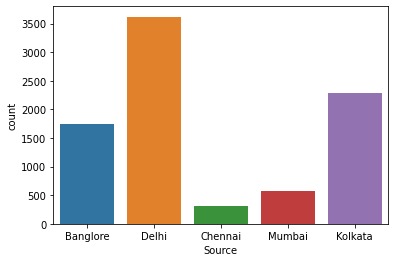

In [7]:
sns.countplot(train["Source"])

In [8]:
train["Source"].value_counts()

Delhi       3619
Kolkata     2291
Banglore    1748
Mumbai       566
Chennai      309
Name: Source, dtype: int64

<AxesSubplot:xlabel='Destination', ylabel='count'>

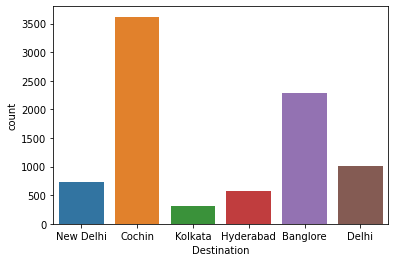

In [9]:
sns.countplot(train["Destination"])

In [10]:
train["Destination"].value_counts()

Cochin       3619
Banglore     2291
Delhi        1018
New Delhi     730
Hyderabad     566
Kolkata       309
Name: Destination, dtype: int64

<AxesSubplot:xlabel='Additional_Info', ylabel='count'>

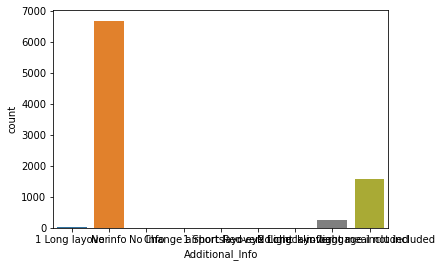

In [11]:
sns.countplot(train["Additional_Info"])

In [12]:
train["Additional_Info"].value_counts()

No info                         6684
In-flight meal not included     1575
No check-in baggage included     249
1 Long layover                    15
Change airports                    5
No Info                            2
Red-eye flight                     1
1 Short layover                    1
2 Long layover                     1
Name: Additional_Info, dtype: int64

<AxesSubplot:xlabel='Total_Stops', ylabel='count'>

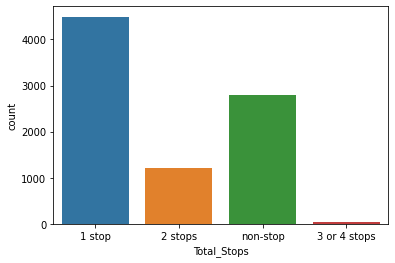

In [13]:
sns.countplot(train["Total_Stops"])

In [14]:
train["Total_Stops"].value_counts()

1 stop          4490
non-stop        2793
2 stops         1214
3 or 4 stops      36
Name: Total_Stops, dtype: int64

<AxesSubplot:xlabel='Duration', ylabel='Price'>

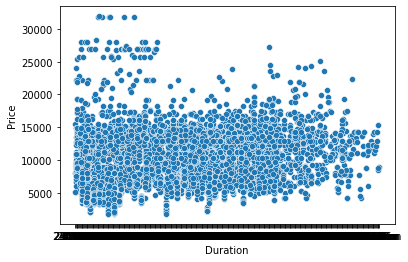

In [15]:
sns.scatterplot(train['Duration'], train['Price'])

<AxesSubplot:xlabel='Source', ylabel='Price'>

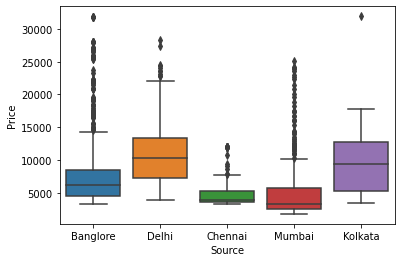

In [16]:
sns.boxplot(train['Source'], train['Price'])

<AxesSubplot:xlabel='Destination', ylabel='Price'>

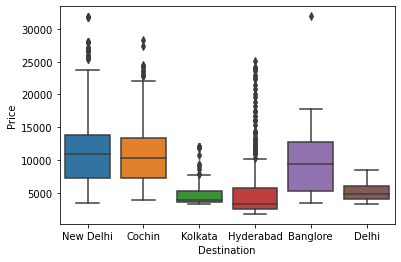

In [17]:
sns.boxplot(train['Destination'], train['Price'])

### Conversion of object to datetime variable

In [18]:
train["Day_of_Journey"]= pd.to_datetime(train.Date_of_Journey,format="%d-%m-%Y").dt.day
train["Month_of_Journey"]= pd.to_datetime(train.Date_of_Journey, format= "%d-%m-%Y").dt.month
test["Day_of_Journey"]= pd.to_datetime(test.Date_of_Journey,format="%d-%m-%Y").dt.day
test["Month_of_Journey"]= pd.to_datetime(test.Date_of_Journey, format= "%d-%m-%Y").dt.month

In [19]:
train.drop(["Date_of_Journey"], axis=1, inplace=True)
test.drop(["Date_of_Journey"], axis=1, inplace=True)

# Feature Engineering

### Creating features with departure time

In [20]:
train["Dep_hr"]= pd.to_datetime(train.Dep_Time).dt.hour
train["Dep_mi"]= pd.to_datetime(train.Dep_Time).dt.minute
train["Arr_hr"]= pd.to_datetime(train.Arrival_Time).dt.hour
train["Arr_mi"]= pd.to_datetime(train.Arrival_Time).dt.minute
train.drop(["Dep_Time"], axis=1, inplace=True)
train.drop(["Arrival_Time"], axis=1, inplace=True)


In [21]:
test["Dep_hr"]= pd.to_datetime(test.Dep_Time).dt.hour
test["Dep_mi"]= pd.to_datetime(test.Dep_Time).dt.minute
test["Arr_hr"]= pd.to_datetime(test.Arrival_Time).dt.hour
test["Arr_mi"]= pd.to_datetime(test.Arrival_Time).dt.minute
test.drop(["Dep_Time"], axis=1, inplace=True)
test.drop(["Arrival_Time"], axis=1, inplace=True)

### Creating features with Duration

In [22]:
## Splitting Duration to hours and minutes

# Assigning and converting Duration column into list
duration = list(train["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration
train["Duration_hours"] = duration_hours
train["Duration_mins"] = duration_mins
train.drop(["Duration"], axis = 1, inplace = True)

In [23]:
## Splitting Duration to hours and minutes

# Assigning and converting Duration column into list
duration2 = list(test["Duration"])

for i in range(len(duration2)):
    if len(duration2[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration2[i]:
            duration2[i] = duration2[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration2[i] = "0h " + duration2[i]           # Adds 0 hour

duration_hrs = []
duration_min = []
for i in range(len(duration2)):
    duration_hrs.append(int(duration2[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_min.append(int(duration2[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration
test["Duration_hours"] = duration_hrs
test["Duration_mins"] = duration_min
test.drop(["Duration"], axis = 1, inplace = True)

### Creating features of Company of Airline, Source, Destination, Total stops and Addtional Info

#### Below we will use label encoder of sklearn

In [24]:
#LABEL ENCODING
encoder = LabelEncoder()
# transform data
train['Airline_encoded'] = pd.DataFrame(encoder.fit_transform(train[['Airline']]))
test['Airline_encoded'] = pd.DataFrame(encoder.fit_transform(test[['Airline']]))
train.drop('Airline', inplace=True, axis=1)
test.drop('Airline', inplace=True, axis=1)


In [25]:
#LABEL ENCODING
encoder = LabelEncoder()
# transform data
train['Source_encoded'] = pd.DataFrame(encoder.fit_transform(train[['Source']]))
test['Source_encoded'] = pd.DataFrame(encoder.fit_transform(test[['Source']]))
train.drop('Source', inplace=True, axis=1)
test.drop('Source', inplace=True, axis=1)

In [26]:
#LABEL ENCODING
encoder = LabelEncoder()
# transform data
train['Destination_encoded'] = pd.DataFrame(encoder.fit_transform(train[['Destination']]))
test['Destination_encoded'] = pd.DataFrame(encoder.fit_transform(test[['Destination']]))
train.drop('Destination', inplace=True, axis=1)
test.drop('Destination', inplace=True, axis=1)

In [27]:
#LABEL ENCODING
train["Total_Stops"]= train["Total_Stops"].replace({'non-stop':0, '2 stops':2, '1 stop':1, '3 or 4 stops':3})
test["Total_Stops"]= test["Total_Stops"].replace({'non-stop':0, '2 stops':2, '1 stop':1, '3 or 4 stops':3})


In [28]:
#LABEL ENCODING
encoder = LabelEncoder()
# transform data
train['Additional_Info_encoded'] = pd.DataFrame(encoder.fit_transform(train[['Additional_Info']]))
test['Additional_Info_encoded'] = pd.DataFrame(encoder.fit_transform(test[['Additional_Info']]))
train.drop('Additional_Info', inplace=True, axis=1)
test.drop('Additional_Info', inplace=True, axis=1)

In [29]:
train['Total_Stops'].value_counts()

1    4490
0    2793
2    1214
3      36
Name: Total_Stops, dtype: int64

## Analyzing Features

<AxesSubplot:>

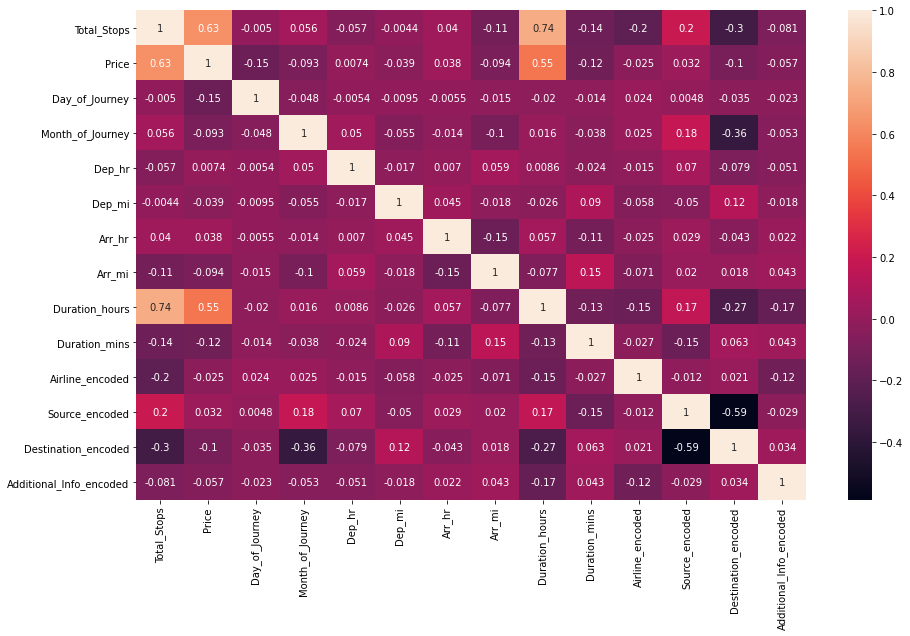

In [30]:
cor = train.corr()
plt.figure(figsize = (15,9))
sns.heatmap(cor, annot = True)

In [31]:
train.corr().loc['Price',: ]

Total_Stops                0.634563
Price                      1.000000
Day_of_Journey            -0.148833
Month_of_Journey          -0.092665
Dep_hr                     0.007446
Dep_mi                    -0.039480
Arr_hr                     0.037955
Arr_mi                    -0.093939
Duration_hours             0.547013
Duration_mins             -0.123659
Airline_encoded           -0.024904
Source_encoded             0.032166
Destination_encoded       -0.100801
Additional_Info_encoded   -0.056926
Name: Price, dtype: float64

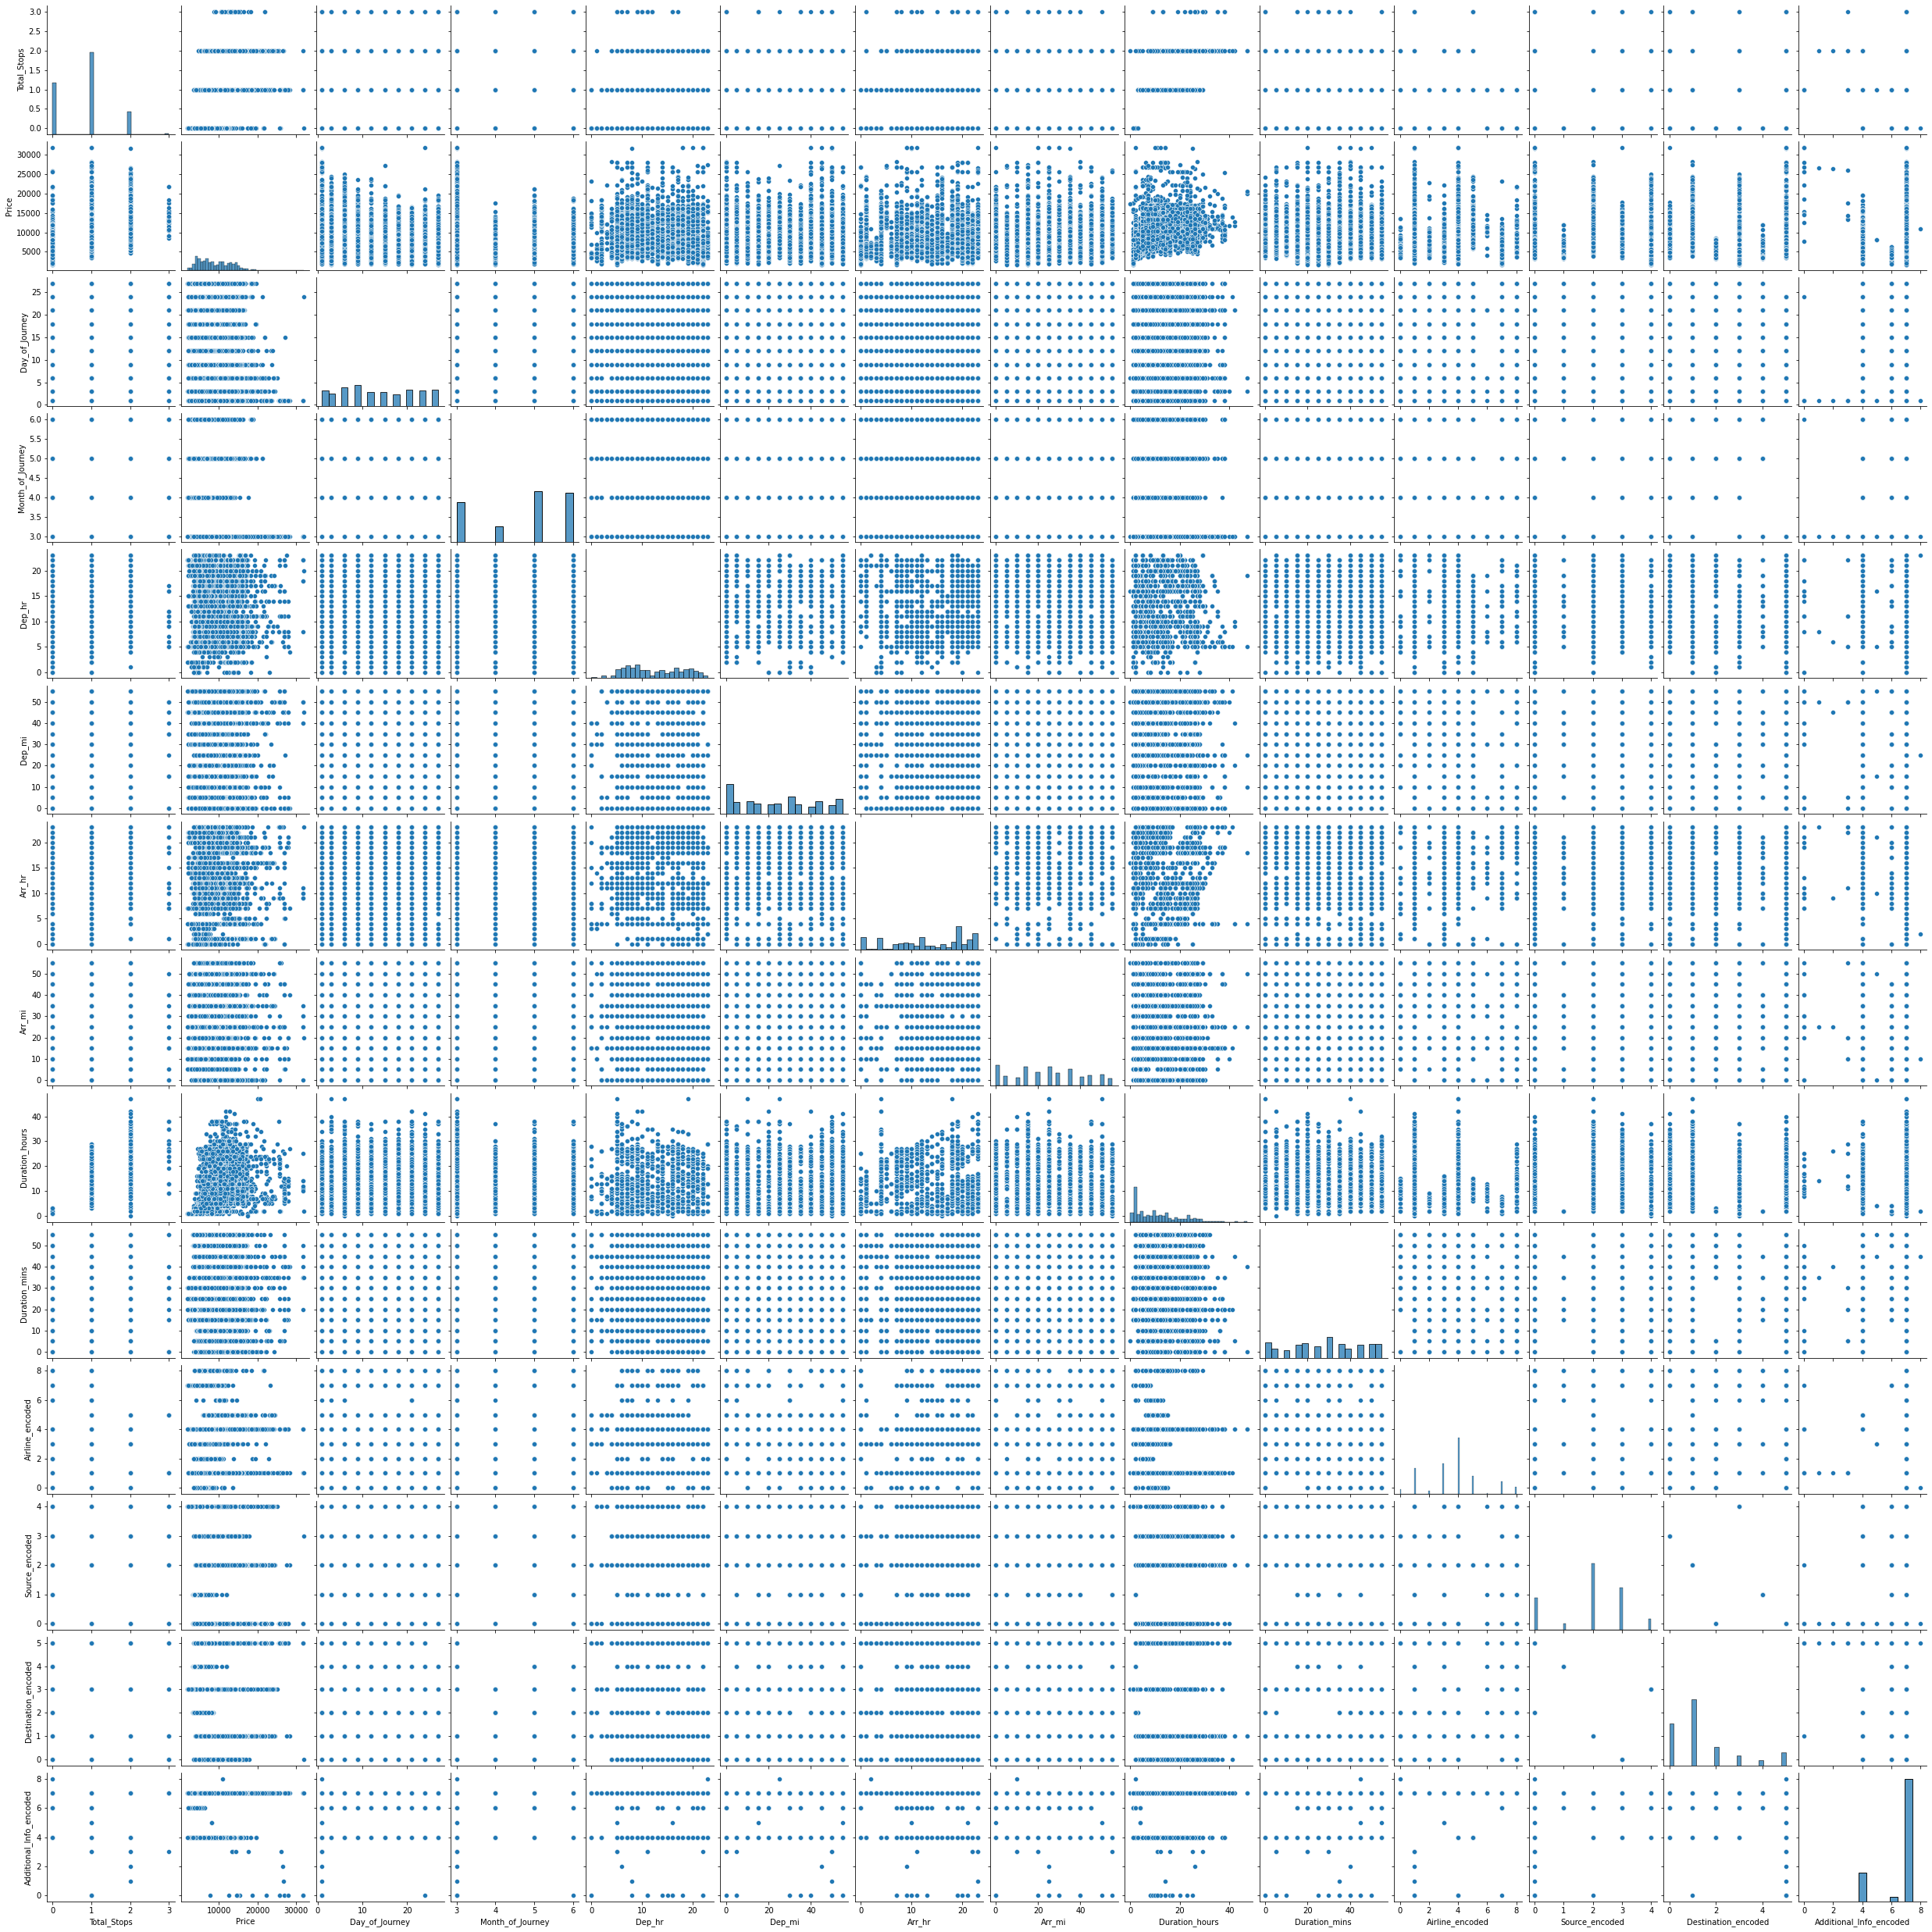

In [32]:
sns.pairplot(data=train)

# Splitting Data

In [33]:
X= train.drop(["Price"],axis=1) ## Features
y= train.Price.values ## Target variable or Label
train.drop('Price', inplace = True, axis=1)
x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=1)
print('Train:',(x_train.shape, y_train.shape))
print('Test:',(x_test.shape, y_test.shape))

Train: ((5973, 13), (5973,))
Test: ((2560, 13), (2560,))


# Model training

## XGBoost

In [34]:
import xgboost as xgb
regr = xgb.XGBRegressor(colsample_bytree = 0.7, learning_rate= 0.05, max_depth=10, min_child_weight= 4, n_estimators= 500, nthread= 8, objective='reg:squarederror', subsample= 0.7)
regr.fit(x_train, y_train)
y_test_pred = np.floor(regr.predict(x_test))
print('Training accuracy=', regr.score(x_train, y_train))
print('Test accuracy=', regr.score(x_test, y_test))
rms = mean_squared_error(y_test, y_test_pred, squared=False)
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("ROOT Mean squared error =",rms)
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_test_pred), 2))

Training accuracy= 0.9936260847165902
Test accuracy= 0.9143031588412551
Mean absolute error = 697.2
Mean squared error = 1583712.26
ROOT Mean squared error = 1258.4562990587417
Median absolute error = 351.5
Explain variance score = 0.91
R2 score = 0.91


### Final Predictions

In [38]:
predict = np.floor(regr.predict(test))
price_predicted= pd.DataFrame(predict, columns=["Price"])
price_predicted.to_csv('Mrinank_price_pred.CSV', index = True, )

In [36]:
price_predicted

,Price
0,5029.0
1,5658.0
2,12826.0
3,3862.0
4,4807.0
...,...
2129,4726.0
2130,11272.0
2131,9709.0
2132,12616.0
